In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
import warnings
import quantstats as qs
from sklearn.linear_model import LinearRegression
from skopt import gp_minimize
from skopt.space import Real
from numpy.fft import fft, fftfreq
from scipy.stats import kstest, normaltest, shapiro
from scipy.special import comb
from sklearn.model_selection import TimeSeriesSplit
warnings.simplefilter('ignore')

In [2]:
# Define constants for short, long, and method
short_period = 6
long_period = 12
ma_method = 'SMA'

class MovingAverageStrategy:
    def __init__(self, short=short_period, long=long_period, method=ma_method):
        self.short = short
        self.long = long
        self.method = method
    def signal(self, index, series):
        x = series.values.astype(float)
        methods = ['EMA','SMA','WMA','DEMA','TEMA','TRIMA','KAMA']
        vals = []
        for m in methods:
            if m == 'EMA':
                a = talib.EMA(x, timeperiod=self.short)
                b = talib.EMA(x, timeperiod=self.long)
            elif m == 'SMA':
                a = talib.SMA(x, timeperiod=self.short)
                b = talib.SMA(x, timeperiod=self.long)
            elif m == 'WMA':
                a = talib.WMA(x, timeperiod=self.short)
                b = talib.WMA(x, timeperiod=self.long)
            elif m == 'DEMA':
                a = talib.DEMA(x, timeperiod=self.short)
                b = talib.DEMA(x, timeperiod=self.long)
            elif m == 'TEMA':
                a = talib.TEMA(x, timeperiod=self.short)
                b = talib.TEMA(x, timeperiod=self.long)
            elif m == 'TRIMA':
                a = talib.TRIMA(x, timeperiod=self.short)
                b = talib.TRIMA(x, timeperiod=self.long)
            elif m == 'KAMA':
                a = talib.KAMA(x, timeperiod=self.short)
                b = talib.KAMA(x, timeperiod=self.long)
            sig = (a - b) > 0
            vals.append(sig.astype(int))
        avg = np.nanmean(np.column_stack(vals), axis=1)
        return pd.DataFrame({'value': avg}, index=index)

In [3]:
class BetaRegressionStrategy:
    def __init__(self, beta_lookback_period=12, zscore_lookback_period=72, signal_threshold=0.75):
        self.beta_lookback_period = beta_lookback_period
        self.zscore_lookback_period = zscore_lookback_period
        self.signal_threshold = signal_threshold
    def signal(self, index, low_series, high_series):
        x = pd.Series(low_series.values.astype(float), index=index)
        y = pd.Series(high_series.values.astype(float), index=index)
        w = self.beta_lookback_period
        mx = x.rolling(w).mean()
        my = y.rolling(w).mean()
        mxx = (x * x).rolling(w).mean()
        myy = (y * y).rolling(w).mean()
        mxy = (x * y).rolling(w).mean()
        varx = mxx - mx * mx
        vary = myy - my * my
        cov = mxy - mx * my
        beta_s = cov / varx
        corr = cov / (np.sqrt(varx) * np.sqrt(vary))
        r2_s = corr * corr
        z = (beta_s - beta_s.rolling(self.zscore_lookback_period).mean()) / beta_s.rolling(self.zscore_lookback_period).std()
        strength = z * r2_s
        weight = strength.where(beta_s > self.signal_threshold, 0.0)
        return pd.DataFrame({'value': weight}, index=index)

In [4]:
class CLV:
    def __init__(self, threshold=-1):
        self.threshold = threshold
    
    def signal(self, index, clv_series):
        y = (clv_series == self.threshold).fillna(0)
        return pd.DataFrame({'value': y.astype(int)}, index=index)

In [11]:
class BreakoutStrategy:
    def __init__(self, ma_long=50, ma_short=20, breakout_lookback=20, atr_period=14):
        self.ma_long = ma_long
        self.ma_short = ma_short
        self.breakout_lookback = breakout_lookback
        self.atr_period = atr_period

    def signal(self, index, low_series, high_series):
        # midpoint close
        close = (low_series + high_series) / 2.0

        # moving averages
        ma_long = close.rolling(self.ma_long).mean()
        ma_short = close.rolling(self.ma_short).mean()

        # breakout levels
        high_n = close.rolling(self.breakout_lookback).max()
        low_n = close.rolling(self.breakout_lookback).min()

        # ATR calculation (using pandas-safe method)
        prev_close = close.shift()
        tr1 = high_n - low_n
        tr2 = (high_n - prev_close).abs()
        tr3 = (low_n - prev_close).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(self.atr_period).mean()

        # breakout conditions
        breakout_up = (close > ma_long) & (close > high_n.shift(1))
        breakout_down = (close < ma_short) & (close < low_n.shift(1))

        # signal output
        signal = pd.Series(0.0, index=index)
        signal.loc[breakout_up] = 1.0
        signal.loc[breakout_down] = -1.0

        signal_smooth = signal.rolling(window=self.ma_short, min_periods=1).mean().fillna(0.0)

        return pd.DataFrame({'value': signal_smooth}, index=index)

In [12]:
class FourierTransform:
    def __init__(self, time_series_datapoints=288, low_energy_threshold=0.5, mid_energy_threshold=0.1,
                 low_slope_threshold=0.0, mid_slope_threshold=0.0):
        self.recents = int(time_series_datapoints)
        self.low_energy_threshold = float(low_energy_threshold)
        self.mid_energy_threshold = float(mid_energy_threshold)
        self.low_slope_threshold = float(low_slope_threshold)
        self.mid_slope_threshold = float(mid_slope_threshold)
        self.low_grid = np.arange(0.01, 0.09, 0.01)
        self.high_grid = np.arange(0.06, 0.21, 0.01)

    def discrete_fourier_transform(self, s, recents):
        x = s.dropna().sort_index().tail(recents)
        n = len(x)
        if n == 0:
            return pd.DataFrame({"frequency": [], "magnitude": []})
        dt = 1.0
        y = x.values
        yf = fft(y)
        xf = fftfreq(n, d=dt)
        pos = xf > 0
        xf = xf[pos]
        mag = np.abs(yf)[pos]
        return pd.DataFrame({"frequency": xf, "magnitude": mag})

    def reconstruct_time_series(self, s, low_filter, high_filter, band):
        x = s.dropna().sort_index()
        y = x.values
        n = len(x)
        if n == 0:
            return pd.Series([], dtype=float)
        F = np.fft.rfft(y, n=n)
        f = np.fft.rfftfreq(n, d=1.0)
        if band == "low":
            mask = f < low_filter
        elif band == "middle":
            mask = (f >= low_filter) & (f <= high_filter)
        else:
            mask = f > high_filter
        y_band = np.fft.irfft(F * mask, n=n)
        return pd.Series(y_band, index=x.index)

    def frequency_filter(self, spec_df, low_filter, high_filter):
        d = spec_df.dropna()
        low = d[d["frequency"] < low_filter]
        mid = d[(d["frequency"] >= low_filter) & (d["frequency"] <= high_filter)]
        high = d[d["frequency"] > high_filter]
        return low, mid, high

    def normality_test(self, arr):
        x = np.asarray(arr)
        if len(x) < 8 or np.allclose(x.std(ddof=1), 0):
            return 1.0, 1.0, 1.0
        z = (x - x.mean()) / x.std(ddof=1)
        return kstest(z, "norm").pvalue, normaltest(x).pvalue, shapiro(x).pvalue

    def seasonality_test(self, spec_df):
        d = spec_df.dropna()
        if len(d) == 0:
            return 1.0
        p = (d["magnitude"].values ** 2)
        mx = float(p.max())
        tot = float(p.sum())
        g = mx / tot if tot > 0 else 0.0
        m = len(p)
        if g <= 0 or m <= 1:
            return 1.0
        kmax = int(np.floor(1.0 / g)) if g > 0 else 0
        pv = 0.0
        for k in range(1, kmax + 1):
            pv += ((-1) ** (k - 1)) * comb(m, k, exact=False) * (1 - k * g) ** (m - 1)
        return float(pv)

    def compute_energy(self, spec_df, low_filter, high_filter):
        d = spec_df.dropna()
        if len(d) == 0:
            return 0.0, 0.0, 0.0
        f = d["frequency"].values
        m2 = (d["magnitude"].values ** 2)
        low = float(m2[f < low_filter].sum())
        mid = float(m2[(f >= low_filter) & (f < high_filter)].sum())
        high = float(m2[f >= high_filter].sum())
        tot = low + mid + high
        if tot > 0:
            low /= tot
            mid /= tot
            high /= tot
        return low, mid, high

    def compute_slope(self, s, inst_regression):
        y = s.dropna().tail(inst_regression).values
        if len(y) < 2:
            return 0.0
        X = np.arange(len(y)).reshape(-1, 1)
        slope = float(LinearRegression().fit(X, y).coef_[0])
        return slope

    def choose_filter_bound(self, s, spec_df, low_grid, high_grid):
        for low in low_grid:
            for high in high_grid:
                if high <= low:
                    continue
                hf = self.reconstruct_time_series(s, low, high, "high")
                r = pd.Series(hf).diff().dropna()
                p1, p2, p3 = self.normality_test(r)
                mid_spec = self.frequency_filter(spec_df, low, high)[1]
                pv_season = self.seasonality_test(mid_spec)
                if (p1 < 0.05) and (p2 < 0.05) and (p3 < 0.05) and (pv_season < 0.05):
                    return float(low), float(high)
        return None

    def signal(self, index, vwap_series):
        s = vwap_series.dropna().sort_index()
        s = np.log(s[s > 0])
        if len(s) < self.recents:
            return pd.DataFrame({'value': pd.Series(0.0, index=index)})
        spec_last = self.discrete_fourier_transform(s, self.recents)
        chosen = self.choose_filter_bound(s, spec_last, self.low_grid, self.high_grid)
        if chosen is None:
            return pd.DataFrame({'value': pd.Series(0.0, index=index)})
        low_f, high_f = chosen
        weights = pd.Series(0.0, index=s.index, dtype=float)
        step = self.recents
        inst_reg = max(8, self.recents // 6)
        for t in range(self.recents, len(s) + 1, step):
            sw = s.iloc[:t].tail(self.recents)
            spec_t = self.discrete_fourier_transform(sw, self.recents)
            el, em, eh = self.compute_energy(spec_t, low_f, high_f)
            low_ts = self.reconstruct_time_series(sw, low_f, high_f, "low")
            mid_ts = self.reconstruct_time_series(sw, low_f, high_f, "middle")
            sl = self.compute_slope(low_ts, inst_reg)
            sm = self.compute_slope(mid_ts, inst_reg)
            ok = (el >= self.low_energy_threshold) and (em >= self.mid_energy_threshold) and (sl >= self.low_slope_threshold) and (sm >= self.mid_slope_threshold)
            w = max(0.0, 1.0 - (eh / el if el > 0 else 1.0) - (eh / em if em > 0 else 1.0)) if ok else 0.0
            weights.iloc[t - 1] = float(w)
        weights = weights.replace(0, np.nan).ffill().fillna(0.0)
        full = pd.Series(0.0, index=index, dtype=float)
        full.loc[weights.index] = weights.values
        full = full.ffill().fillna(0.0)
        return pd.DataFrame({'value': full}, index=index)

In [13]:
data = 'OHLCV_5m_Roostoo'
initial_cash = 100000
commissions = 0.001
lambda_value = 0.9 # Exponential Weighting Factor, higher value means higher weight for present indicator
change_threshold = 0.05 # Change in crypto weight required for entering a new trade
start_time ='2024-09-01 00:00:00' #Modify start, end, signal_series, and rebalance to backtest
end_time ='2025-08-31 23:55:00'

rebalance = 'D'
# '5T' for 5-minute intervals
# '1H' for 1-hour intervals
# 'D' for daily
# 'W' for weekly

class Backtester:
    def __init__(self, data_dir=data, strategy_class=None, initial_cash=initial_cash,
                 commissions=commissions, rebalance=rebalance, lambda_value=lambda_value, 
                 change_threshold=change_threshold, start=start_time, end=end_time): 
        self.data_dir = data_dir
        self.initial_cash = initial_cash
        self.commissions = commissions
        self.rebalance = rebalance
        self.lambda_value = lambda_value
        self.change_threshold = change_threshold
        self.start_time = start
        self.end_time = end

        self.data = self.load_data()
        self.open = self.build_matrix('open')
        self.high = self.build_matrix('high')
        self.low = self.build_matrix('low')
        self.volume = self.build_matrix('volume')
        self.close = self.build_matrix('close')
        self.vwap = self.build_matrix('vwap')
        self.clv = self.build_matrix('clv')
        
        self.strategy = BreakoutStrategy()  #MODIFY TO CHANGE STRATEGY HERE
        if isinstance(self.strategy, BetaRegressionStrategy):
            self.series_names = ['low','high']
        elif isinstance(self.strategy, BreakoutStrategy):
            self.series_names = ['low','high']
        elif isinstance(self.strategy, CLV):
            self.series_names = ['clv']
        elif isinstance(self.strategy, MovingAverageStrategy):
            self.series_names = ['vwap']
        elif isinstance(self.strategy, FourierTransform):
            self.series_names = ['vwap']
        self.weights_raw = self.build_weights()
        self.exp_weights = self.exponential_weights(self.weights_raw)
        self.weights = self.positions(self.exp_weights)
        self.returns = self.close.pct_change().fillna(0.0)
        self.equity_curve = self.compute_equity_curve()
        self.metrics = self.compute_risk_metrics

    def load_data(self):
        out = {}
        for fp in sorted(glob.glob(f"{self.data_dir}/*.csv")):
            df = pd.read_csv(fp, parse_dates=['timestamp'], index_col='timestamp').sort_index()
            df = df.loc[start_time:end_time]
            base = re.sub(r'USDT$', '', os.path.basename(fp).split('_')[0]) # Remove USDT from column name
            out[base] = df[['open','high','low','close','volume','vwap','clv']]
        return out

    def build_matrix(self, col):
        cols = []
        for sym, df in self.data.items():
            cols.append(df[col].rename(sym))
        return pd.concat(cols, axis=1).sort_index()

    def build_weights(self):
        names = getattr(self, 'series_names', ['vwap'])
        srcs = [getattr(self, n) for n in names]
        def call_signal(sym):
            args = [src[sym] for src in srcs]
            return self.strategy.signal(self.close.index, *args)['value']
        columns = srcs[0].columns
        sig_dict = {sym: call_signal(sym) for sym in columns}
        sig_df = pd.DataFrame(sig_dict).fillna(0)
        sig_df = sig_df.resample(self.rebalance).last().shift(1).fillna(0)
        return sig_df

    def exponential_weights(self, weights_df, lam=lambda_value):
        ew = pd.DataFrame(index=weights_df.index, columns=weights_df.columns, dtype=float)
        ew.iloc[0] = weights_df.iloc[0].clip(lower=0.0)
        for i in range(1, len(weights_df)):
            ew.iloc[i] = lam * weights_df.iloc[i].clip(lower=0.0) + (1.0 - lam) * ew.iloc[i-1]
        ew = ew.div(ew.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
        return ew

    def positions(self, exp_weights_df, trade_threshold=change_threshold):
        if trade_threshold is None:
            trade_threshold = self.change_threshold
        idx = exp_weights_df.index
        pos = pd.DataFrame(index=idx, columns=exp_weights_df.columns, dtype=float)
        w0 = exp_weights_df.iloc[0].clip(lower=0.0)
        pos.iloc[0] = w0.div(w0.sum() if w0.sum() != 0 else 1.0)
        for i in range(1, len(idx)):
            w = exp_weights_df.iloc[i].clip(lower=0.0)
            prev = pos.iloc[i - 1]
            changed = (w - prev).abs() >= trade_threshold
            if changed.sum() <= 1:
                pos.iloc[i] = prev
                continue
            keep = ~changed
            free = 1.0 - float(prev[keep].sum())
            if free <= 0.0:
                pos.iloc[i] = prev
                continue
            t = w[changed]
            t = t.div(t.sum() if t.sum() != 0 else 1.0)
            new = prev.copy()
            new.loc[changed] = t * free
            ch_sum = float(new[changed].sum())
            need = 1.0 - float(new[keep].sum())
            if ch_sum != need and ch_sum > 0:
                new.loc[changed] = new[changed] / ch_sum * need
            if (new - prev).abs().max() <= trade_threshold:
                pos.iloc[i] = prev
                continue
            pos.iloc[i] = new
        return pos

    def compute_equity_curve(self):
        idx = self.returns.index
        w = self.weights.reindex(idx).ffill().fillna(0.0)
        w_prev = w.shift(1).fillna(0.0)
        gross = (w_prev * self.returns).sum(axis=1)
        turn = w.diff().abs().sum(axis=1).shift(1).fillna(0.0)
        net = gross - self.commissions * turn
        equity = (1.0 + net).cumprod() * self.initial_cash
        self.portfolio_value = float(equity.iloc[-1])
        self.net_returns = net
        self.turn = turn
        return equity.to_frame('portfolio_value')

    def compute_risk_metrics(self, r=None):
        r = self.net_returns if r is None else r
        per_year = 365*24*12
        sharpe = qs.stats.sharpe(r, periods=per_year)
        sortino = qs.stats.sortino(r, periods=per_year)
        calmar = qs.stats.calmar(r, periods=per_year)
        ann_ret = qs.stats.cagr(r, periods=per_year)
        max_dd = qs.stats.max_drawdown(r)
        num_trades = int((self.turn > 0).sum()) if r is self.net_returns else 0
        return pd.Series({
            'annualized_return': ann_ret,
            'max_drawdown': max_dd,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino,
            'calmar_ratio': calmar,
            'num_trades': num_trades
        })

    def compute_benchmark(self):
        idx = self.returns.index
        n = len(self.close.columns)
        w = pd.DataFrame(1.0 / n, index=idx, columns=self.close.columns)
        w_prev = w.shift(1).fillna(0.0)
        bench_returns = (w_prev * self.returns).sum(axis=1)
        bench_equity = (1.0 + bench_returns).cumprod() * self.initial_cash
        bench_metrics = self.compute_risk_metrics(bench_returns)
        return bench_equity, bench_returns, bench_metrics

    def strategy_vs_benchmark(self, bench_returns):
        lr = LinearRegression(fit_intercept=True)
        df = pd.concat([self.net_returns, bench_returns], axis=1).dropna()
        df.columns = ['strategy','benchmark']
        X = df['benchmark'].values.reshape(-1, 1)
        y = df['strategy'].values
        lr.fit(X, y)
        beta = float(lr.coef_[0])
        alpha = float(lr.intercept_)
        corr = float(df['strategy'].corr(df['benchmark']))
        print(f"Alpha: {alpha:.8f}")
        print(f"Beta: {beta:.8f}")
        print(f"Correlation: {corr:.8f}")
        return alpha, beta

bt = Backtester()

Portfolio Risk Metrics:
annualized_return     0.964930
max_drawdown         -0.635849
sharpe_ratio          1.224124
sortino_ratio         1.705148
calmar_ratio          1.517544
num_trades           47.000000
dtype: float64
Benchmark Risk Metrics:
annualized_return    0.594838
max_drawdown        -0.663359
sharpe_ratio         0.975975
sortino_ratio        1.357882
calmar_ratio         0.896706
num_trades           0.000000
dtype: float64
Strategy vs Benchmark:
Alpha: 0.00000206
Beta: 0.98856274
Correlation: 0.99027596
(2.062685548196871e-06, 0.9885627432344711)


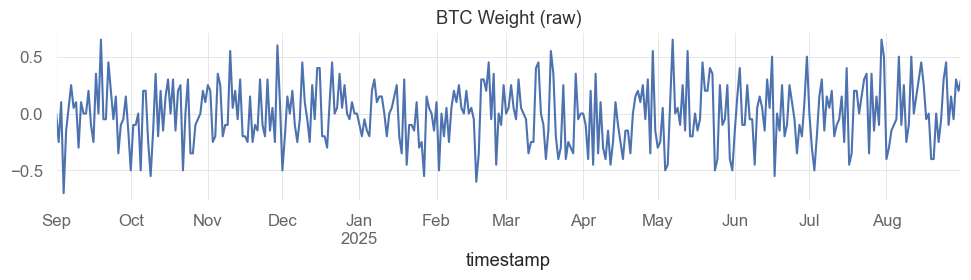

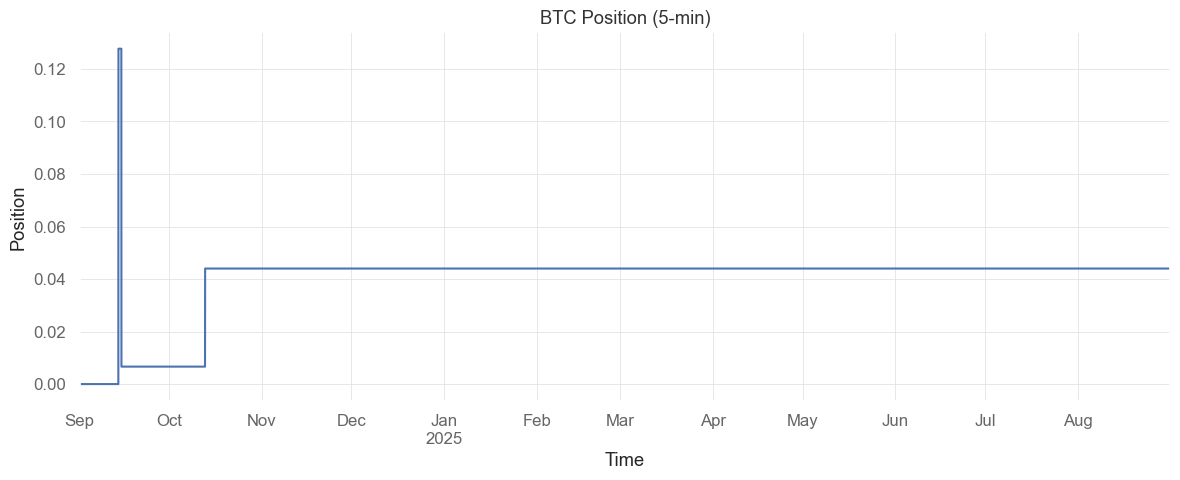

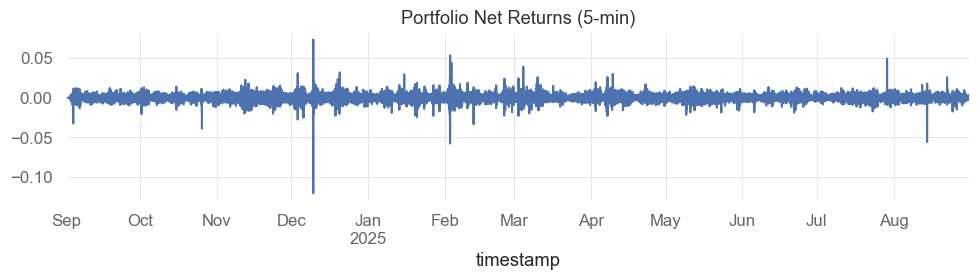

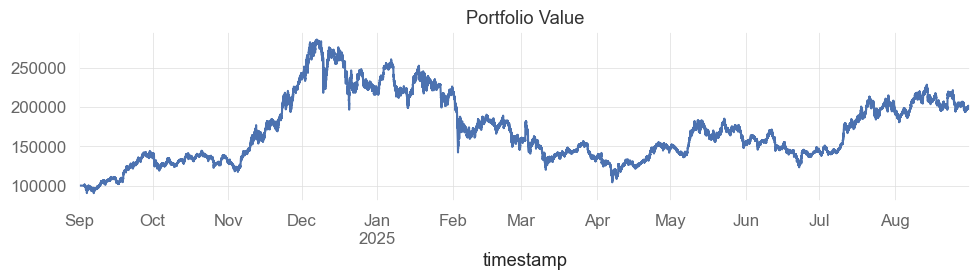

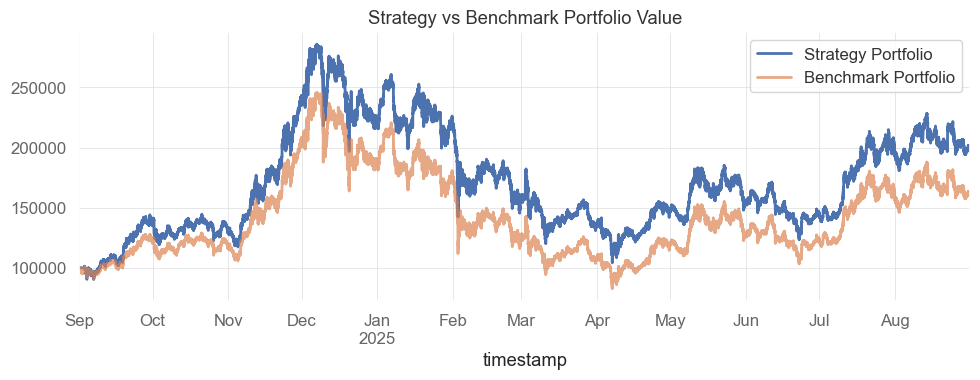

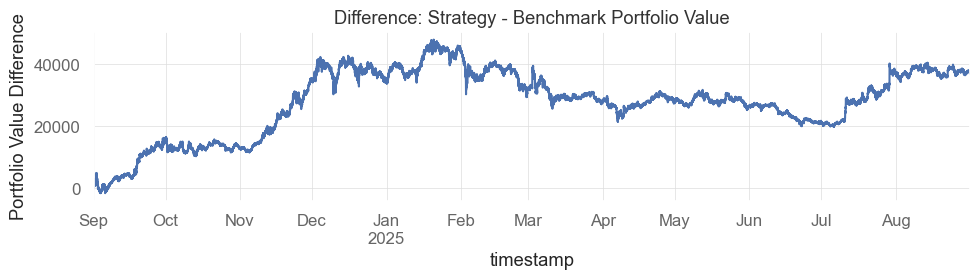

In [8]:
coin = 'BTC'
plt.figure(figsize=(10,3))
bt.weights_raw[coin].plot(title='BTC Weight (raw)')
plt.tight_layout()

# Plot the output DataFrame of the position function (all assets)
pos_5m = bt.positions(bt.exponential_weights(bt.weights_raw)).reindex(bt.returns.index).ffill().fillna(0.0)
plt.figure(figsize=(12, 5))
pos_5m[coin].plot(title=f'{coin} Position (5-min)')
plt.ylabel('Position')
plt.xlabel('Time')
plt.tight_layout()

plt.figure(figsize=(10,3))
bt.net_returns.plot(title='Portfolio Net Returns (5-min)')
plt.tight_layout()

plt.figure(figsize=(10,3))
bt.equity_curve['portfolio_value'].plot(title='Portfolio Value')
plt.tight_layout()

print('Portfolio Risk Metrics:')
print(bt.compute_risk_metrics())

bench_equity, bench_returns, bench_metrics = bt.compute_benchmark()
print('Benchmark Risk Metrics:')
print(bench_metrics)
print('Strategy vs Benchmark:')
print(bt.strategy_vs_benchmark(bench_returns))

plt.figure(figsize=(10, 4))
bt.equity_curve['portfolio_value'].plot(label='Strategy Portfolio', linewidth=2)
bench_equity.plot(label='Benchmark Portfolio', linewidth=2, alpha=0.7)
plt.title('Strategy vs Benchmark Portfolio Value')
plt.legend()
plt.tight_layout()

diff = bt.equity_curve['portfolio_value'] - bench_equity
plt.figure(figsize=(10, 3))
diff.plot(title='Difference: Strategy - Benchmark Portfolio Value')
plt.ylabel('Portfolio Value Difference')
plt.tight_layout()

plt.show()

In [65]:
class HyperparameterOptimization:
    def __init__(self, optimize_params=None, lam_range=(0.8, 1.0), th_range=(0.0, 0.2), freq='D'):
        self.optimize_params = optimize_params or {'lam': True, 'th': True}
        self.lam_range = lam_range
        self.th_range = th_range
        self.freq = freq
        self.default_lam = 1.0
        self.default_th = 0.0
        self.short = short_period
        self.long = long_period
        self.method = ma_method
        self.beta_lookback_period = 12
        self.zscore_lookback_period = 72
        self.signal_threshold = 0.75
        self.time_series_datapoints = 288
        self.low_energy_threshold = 0.7
        self.mid_energy_threshold = 0.2
        self.low_slope_threshold = 0.0
        self.mid_slope_threshold = 0.0

    def compute_annualized_log_returns(self, lam, th, freq, data='train'):
        bt = Backtester(rebalance=freq)
        wr = bt.build_weights()
        ew = bt.exponential_weights(wr, lam=lam)
        w = bt.positions(ew, trade_threshold=th)
        idx = bt.returns.index
        n = len(idx)
        cut = int(n * 0.8)
        idx_sub = idx[:cut] if str(data).lower() == 'train' else idx[cut:]
        wf = w.reindex(idx_sub).ffill().fillna(0.0)
        ret_sub = bt.returns.reindex(idx_sub)
        gross = (wf.shift(1).fillna(0.0) * ret_sub).sum(axis=1)
        turn = wf.diff().abs().sum(axis=1).shift(1).fillna(0.0)
        net = gross - bt.commissions * turn
        per_year = 365 * 24 * 12
        m = len(net)
        ann_log = float(np.log1p(net).sum()) * (per_year / m) if m > 0 else 0.0
        return ann_log

    def objective_function(self, lam, th, freq):
        bt = Backtester(rebalance=freq)
        wr = bt.build_weights()
        ew = bt.exponential_weights(wr, lam=lam)
        w = bt.positions(ew, trade_threshold=th)
        idx = bt.returns.index
        tscv = TimeSeriesSplit(n_splits=3)
        scores = []
        for _, val_idx in tscv.split(np.arange(len(idx))):
            idx_val = idx[val_idx]
            wf = w.reindex(idx_val).ffill().fillna(0.0)
            ret_val = bt.returns.reindex(idx_val)
            gross = (wf.shift(1).fillna(0.0) * ret_val).sum(axis=1)
            turn = wf.diff().abs().sum(axis=1).shift(1).fillna(0.0)
            net = gross - bt.commissions * turn
            m = len(net)
            per_year = 365 * 24 * 12
            ann_log = float(np.log1p(net).sum()) * (per_year / m) if m > 0 else 0.0
            scores.append(ann_log)
        return -float(np.mean(scores)) if len(scores) > 0 else 0.0

    def optimize(self):
        space = []
        lam_low, lam_high = self.lam_range
        th_low, th_high = self.th_range
        space.append(Real(lam_low, lam_high) if self.optimize_params.get('lam', True) else Real(self.default_lam, self.default_lam))
        space.append(Real(th_low, th_high) if self.optimize_params.get('th', True) else Real(self.default_th, self.default_th))
        def obj(params):
            lam, th = params
            return self.objective_function(lam, th, self.freq)
        res = gp_minimize(obj, space, n_calls=15, random_state=0)
        lam_best, th_best = res.x
        return lam_best, th_best

    def comparative_metrics(self):
        lam_best, th_best = self.optimize()
        opt_test = self.compute_annualized_log_returns(lam_best, th_best, self.freq, data='test')
        def_test = self.compute_annualized_log_returns(1.0, 0.0, 'D', data='test')
        bt = Backtester(rebalance=self.freq)
        idx = bt.returns.index
        cut = int(len(idx) * 0.8)
        idx_test = idx[cut:]
        n = len(bt.close.columns)
        w_eq = pd.DataFrame(1.0 / n, index=idx_test, columns=bt.close.columns)
        gross_eq = (w_eq.shift(1).fillna(0.0) * bt.returns.reindex(idx_test)).sum(axis=1)
        net_eq = gross_eq
        per_year = 365 * 24 * 12
        m = len(net_eq)
        ew_test = float(np.log1p(net_eq).sum()) * (per_year / m) if m > 0 else 0.0
        out = pd.DataFrame({'annualized_log_return': [opt_test, def_test, ew_test]},
                           index=['optimized', 'default', 'equal_weight'])
        w_opt = bt.positions(bt.exponential_weights(bt.build_weights(), lam=lam_best), trade_threshold=th_best).reindex(idx_test).ffill().fillna(0.0)
        net_opt = (w_opt.shift(1).fillna(0.0) * bt.returns.reindex(idx_test)).sum(axis=1) - bt.commissions * w_opt.diff().abs().sum(axis=1).shift(1).fillna(0.0)
        eq_opt = (1.0 + net_opt).cumprod()
        w_def = bt.positions(bt.exponential_weights(bt.build_weights(), lam=1.0), trade_threshold=0.0).reindex(idx_test).ffill().fillna(0.0)
        net_def = (w_def.shift(1).fillna(0.0) * bt.returns.reindex(idx_test)).sum(axis=1)
        eq_def = (1.0 + net_def).cumprod()
        eq_eq = (1.0 + net_eq).cumprod()
        # Return equity curves for plotting externally as a dict
        equity_curves = {
            'Optimized': eq_opt,
            'Default': eq_def,
            'Equal Weight': eq_eq
        }
        return out, equity_curves

(0.8408507689137682, 0.16567680094419313)
              annualized_log_return
optimized                  1.365697
default                    1.045273
equal_weight               1.458524


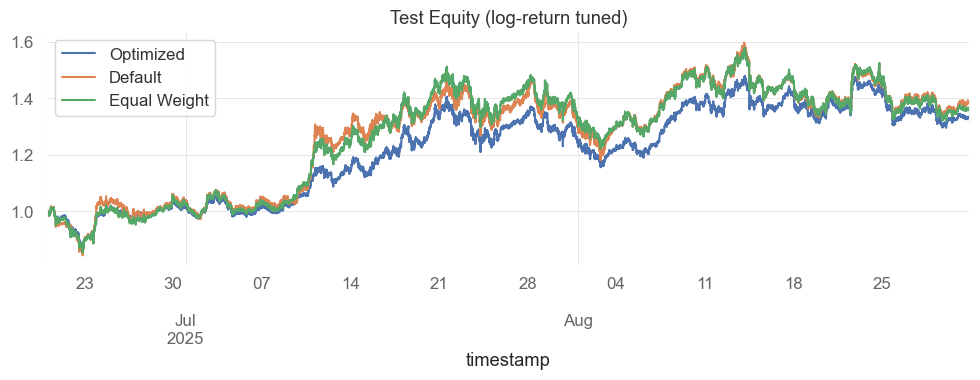

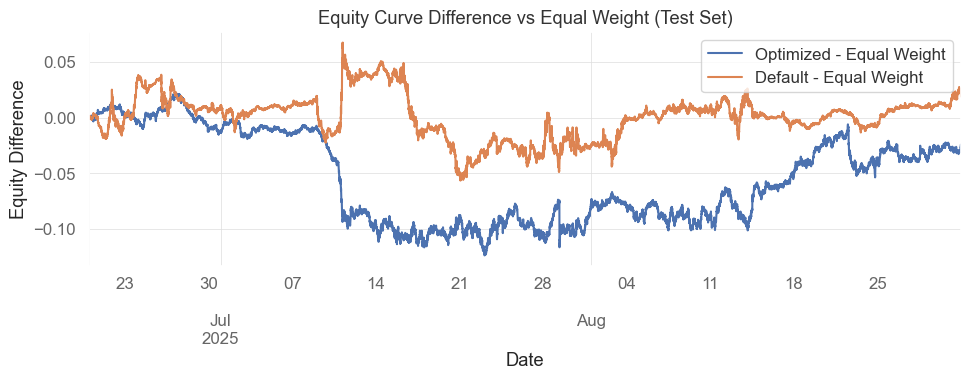

In [66]:
opt = HyperparameterOptimization()
print(opt.optimize())

out, equity_curves = opt.comparative_metrics()
print(out)

plt.figure(figsize=(10, 4))
for label, curve in equity_curves.items():
    curve.plot(label=label)
plt.title('Test Equity (log-return tuned)')
plt.legend()
plt.tight_layout()
plt.show()

diff_opt_eq = equity_curves['Optimized'] - equity_curves['Equal Weight']
diff_def_eq = equity_curves['Default'] - equity_curves['Equal Weight']

plt.figure(figsize=(10, 4))
diff_opt_eq.plot(label="Optimized - Equal Weight")
diff_def_eq.plot(label="Default - Equal Weight")
plt.title("Equity Curve Difference vs Equal Weight (Test Set)")
plt.xlabel("Date")
plt.ylabel("Equity Difference")
plt.legend()
plt.tight_layout()
plt.show()